In [37]:
import DataAnalysis as da
import numpy as np
import pickle
import matplotlib.pyplot as plt
import scipy.optimize as opt
%matplotlib inline

In [88]:
with open(f"pickled_fit", 'rb') as file:
    var = pickle.load(file=file)
    x_calibration = var["x"]
    y_calibration = var["y"]
    
def fit_func(x, x_lst, y_lst):
    def helperClosest(x, lst):
        assert x >= min(lst) and x <= max(lst), f"x={x} is not in [{min(lst)},{max(lst)}]"
        range_lst = max(lst) - min(lst)
        x = x - min(lst)
        low_index = int(x//1e-9)
        high_index = low_index + 1
        return low_index, high_index
    def helperFarthest(x):
        a, b = helperClosest(x, x_lst)
        b_weight = (x-x_lst[a])/(x_lst[b]-x_lst[a])
        a_weight = 1 - b_weight
        return a_weight*y_lst[a] + b_weight*y_lst[b]
    if (type(x)==type([])):
        return [helperFarthest(val) for val in x]
    return helperFarthest(x)
calibration_model = lambda x: [fit_func(val, x_calibration, y_calibration) for val in x]

### Trial 1 - Load in Data for Peak Wavelength vs Photocurrent, Convert units, Propagate Error in Wavelength

In [40]:
wavelength = np.array([510, 480, 450, 520, 530, 550, 575, 565, 540, 585, 600]) #nanometers
w_err = 7e-9 #meters
wavelength_m = np.array([(1e-9)*i for i in wavelength]) #wavelength in meters

wavelength_with_error = da.get_uncertain_array(wavelength_m, w_err) #propagate error

photocurrent_nA = np.array([43, 29, 14, 40, 32, 18, 3, 7, 32, 3, 0]) #nanoamps
photocurrent = np.array([(1e-9)*i for i in photocurrent_nA]) #Amps
p_err = 4e-9 #Amps, #Error in photocurrent as observed in lab

def frequency(w):
    "Function for converting wavelengths to frequencies"
    return (3*(1e8))/w

freq_with_error = np.array([frequency(i) for i in wavelength_with_error]) #frequency data with error as single object

#Divide frequency array into separate frequency and error objects
freq = da.seperate_uncertainty_array(freq_with_error) #Hertz

### Plot of frequency vs. photocurrent

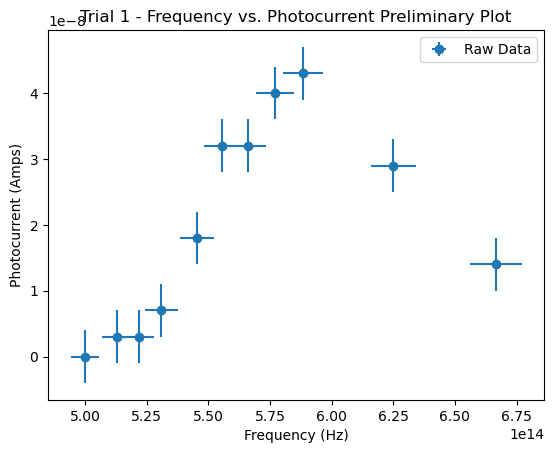

In [43]:
plt.figure()
plt.title("Trial 1 - Frequency vs. Photocurrent Preliminary Plot")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Photocurrent (Amps)")
plt.errorbar(x=freq[0], y=photocurrent, xerr=freq[1], yerr=p_err, fmt="o", label="Raw Data")
plt.legend()

### Ayu Section: Weighted Fit for data

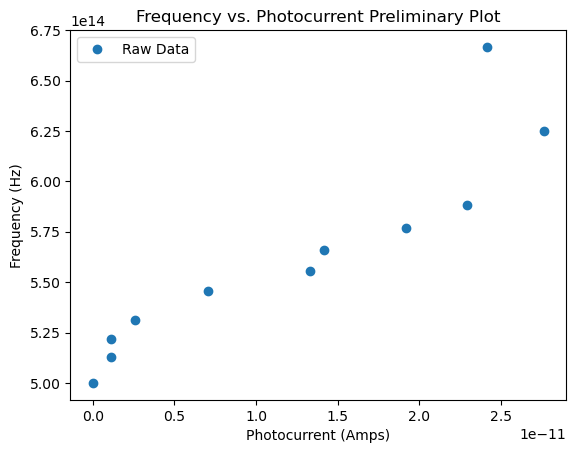

In [45]:
##use linear fit, then analyze fit after normalizing with garima's model.
wave = [3e8/f for f in freq[0]]
weighted_photocurrent = np.divide(photocurrent, calibration_model(wave))
plt.figure()
plt.title("Frequency vs. Photocurrent Preliminary Plot")
plt.ylabel("Frequency (Hz)")
plt.xlabel("Photocurrent (Amps)")
plt.errorbar(x=weighted_photocurrent, y=freq[0], fmt="o", label="Raw Data")
plt.legend()

In [46]:
da.weighted_least_squares_linear(weighted_photocurrent[2:-2], freq[0][2:-2],np.ones(len(freq[0][2:-2])))

m = 5.1e+24±4.8e+10, c = 5.1e+14±0.67, Χ² = 2.9e+27
Equation: y = (5.1e+24±4.8e+10)*x + (5.1e+14±0.67)


([5.051764083647548e+24, 507420395696818.44],
 [47943448580.31653, 0.6737743198815253],
 [array([6.29216733e+14, 6.04158105e+14, 5.78794418e+14, 5.42918703e+14,
         5.12994162e+14, 5.20524454e+14, 5.74743589e+14]),
  array([-3.74499336e+13,  2.72350277e+13,  1.27566822e+13, -2.53584266e+12,
         -8.74496890e+12, -1.04489977e+13,  1.91880330e+13])],
 [2.867244346703723e+27])

In [47]:
1/(5.1e+24/4.475e6)

##CORRECT CUTOFF FREQUENCY BY 5% AT END TO ACCOUNT FOR CALIBRATION ERRORS

8.77450980392157e-19

### Normalize Trial 1

<ErrorbarContainer object of 3 artists>

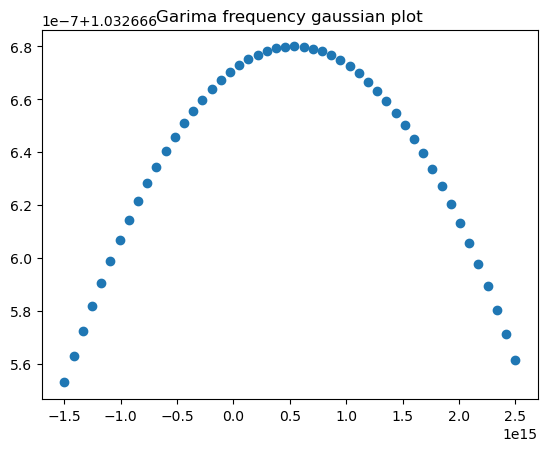

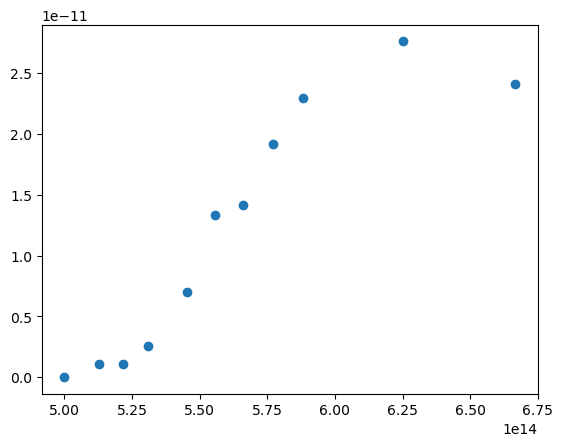

In [86]:
##use linear fit, then analyze fit after normalizing with garima's model.

#frequency parameters = [1.03266668, 5.34959567e14, 4.10344728e18] 

#Garima Gaussian model in frequency space
def gaussian(x, a, b, c):
    
    return a*np.exp((-1*np.subtract(x,b)**2)/(2*c**2))

a = 1.03266668 
b= 5.34959567e14
c= 4.10344728e18

x=np.linspace(-15e14,25e14)
plt.figure()
plt.title("Garima frequency gaussian plot")
plt.plot(x, gaussian(x, a, b, c), 'o')

#Normalize trial 1 data
photocurrent_normalized = np.divide(photocurrent, calibration_model(wave))
plt.figure()
plt.errorbar(y=photocurrent_normalized, x=freq[0], fmt='o')

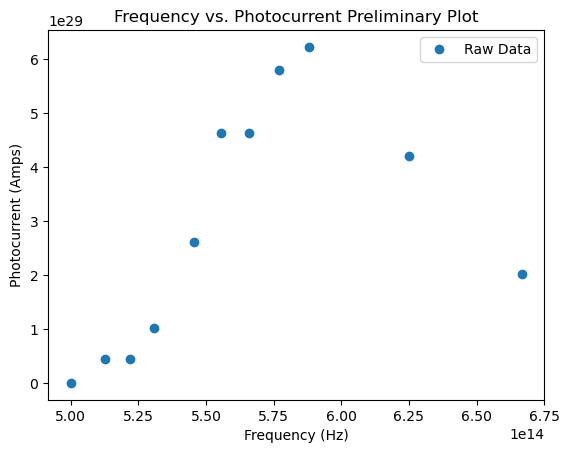

In [55]:
##use linear fit, then analyze fit after normalizing with garima's model.
weighted_photocurrent = np.divide(photocurrent, gaussian(wavelength_m, a, b, c))
plt.figure()
plt.title("Frequency vs. Photocurrent Preliminary Plot")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Photocurrent (Amps)")
plt.errorbar(y=weighted_photocurrent, x=freq[0], fmt="o", label="Raw Data")
plt.legend()

In [25]:
da.weighted_least_squares_linear(weighted_photocurrent, freq[0],np.ones(len(freq[0])))

m = 1.1e-16±1.4e-30, c = 5.3e+14±0.5, Χ² = 1.9e+28
Equation: y = (1.1e-16±1.4e-30)*x + (5.3e+14±0.5)


([1.1142765495153714e-16, 530265959829093.75],
 [1.385780166902865e-30, 0.5033363477284971],
 [array([5.99626402e+14, 5.77043933e+14, 5.52848430e+14, 5.94787301e+14,
         5.81883033e+14, 5.59300563e+14, 5.35105060e+14, 5.41557194e+14,
         5.81883033e+14, 5.35105060e+14, 5.30265960e+14]),
  array([ 1.13911078e+13, -4.79560671e+13, -1.13818237e+14,  1.78642242e+13,
          1.58452969e+13,  1.38460177e+13,  1.33659299e+13,  1.05837431e+13,
          2.63274770e+13,  2.22845475e+13,  3.02659598e+13])],
 [1.8542478039755802e+28])

### Trial 2 Stopping Frequency

In [7]:
wavelength_2 = np.array([590, 585, 565, 550, 530, 510, 495, 475, 473, 603, 443]) #nanometers
w_err_2 = 7e-9 #meters
wavelength_m_2 = np.array([(1e-9)*i for i in wavelength_2]) #wavelength in meters

wavelength_with_error_2 = da.get_uncertain_array(wavelength_m_2, w_err_2) #propagate error

photocurrent_nA_2 = np.array([3, 7, 10, 18, 21, 25, 14, 10, 3, 0, 0]) #nanoamps
photocurrent_2 = np.array([(1e-9)*i for i in photocurrent_nA_2]) #Amps
p_err_2 = 4e-9 #Amps, #Error in photocurrent as observed in lab

def frequency(w):
    "Function for converting wavelengths to frequencies"
    return (3*(1e8))/w

freq_with_error_2 = np.array([frequency(i) for i in wavelength_with_error_2]) #frequency data with error as single object

#Divide frequency array into separate frequency and error objects
freq_2 = da.seperate_uncertainty_array(freq_with_error_2) #Hertz
print(photocurrent_nA_2)

[ 3  7 10 18 21 25 14 10  3  0  0]


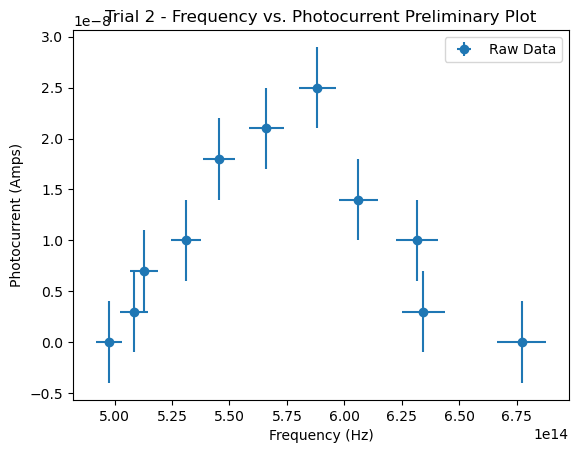

In [8]:
plt.figure()
plt.title("Trial 2 - Frequency vs. Photocurrent Preliminary Plot")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Photocurrent (Amps)")
plt.errorbar(x=freq_2[0], y=photocurrent_2, xerr=freq_2[1], yerr=p_err_2, fmt="o", label="Raw Data")
plt.legend()

<ErrorbarContainer object of 3 artists>

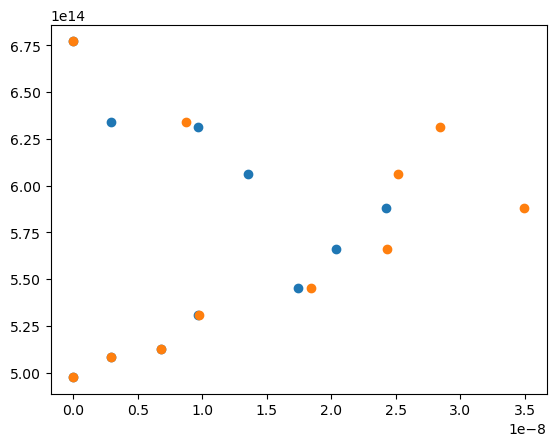

In [98]:
#Normalize trial 2 data
max_gau = max(gaussian(freq_2[0], a, b, c))
max_cal = max(calibration_model(np.divide(3e8, freq_2[0])))
photocurrent_normalized_2 = np.divide(photocurrent_2, gaussian(freq_2[0], a, b, c))
photocurrent_normalized_3 = np.divide(photocurrent_2, np.multiply(max_gau/max_cal,calibration_model(np.divide(3e8, freq_2[0]))))
plt.figure()
plt.errorbar(x=photocurrent_normalized_2, y=np.multiply(freq_2[0], 1), fmt='o')
plt.errorbar(x=photocurrent_normalized_3, y=freq_2[0], fmt='o')

<ErrorbarContainer object of 3 artists>

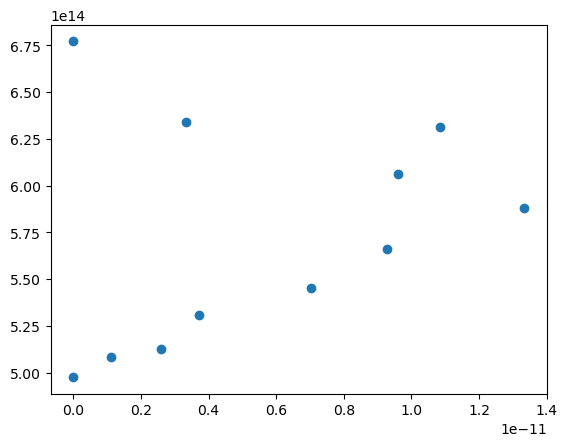

In [91]:
#Normalize trial 2 data
#photocurrent_normalized_2 = np.divide(photocurrent_2, gaussian(freq_2[0], a, b, c))
photocurrent_normalized_2 = np.divide(photocurrent_2, calibration_model(np.divide(3e8, freq_2[0])))
plt.figure()
plt.errorbar(x=photocurrent_normalized_2, y=freq_2[0], fmt='o')